# Project Overview

## Mitigating Class Imbalance
- Examining the confusion matrix, describe how the accuracy for each class may (or may not) correlate with:
  - Class imbalances
  - lack of sufficient training examples (a low shot problem)
  - both of the above

- Design and run an experiment examining how test accuracy changes when one or both of the class imbalance and low shot case exist. You are free to decide how to design this.
  - Demonstrate how the effect can be quantified (decide on what metrics do you use to quantify this)
  - identify in the literature or develop your own strategy for dealing with class imbalances or low shot
    - run an experiment demonstrating how well your proposed solution works on the street sign classification problem.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!unzip /content/drive/MyDrive/GTSRB_Final_Training_Images.zip

In [3]:
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

# Helper Functions

In [4]:
from collections import Counter

def view_data_distribution(dataset):
    distribution = dict(Counter(dataset.targets))
    
    keys = list(distribution.keys())
    values = list(distribution.values())

    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    ax.set_title('GTSR Data Imbalances')
    ax.set_xlabel('Example count (int)')
    ax.set_ylabel('Class (int)')

    plt.barh(keys, values)

    for index, value in enumerate(values):
        plt.text(value, index, str(value))

    fig.savefig('data_imbalance', dpi=300)
    fig.show()

def imshow(img):
  img = img/ 2 + 0.5
  # npimg = img.numpy()
  plt.imshow(np.transpose(img[0].numpy(), (1,2,0)))
  plt.show()

# Define Transformations

In [5]:
# https://github.com/poojahira/gtsrb-pytorch

standard_transform = transforms.Compose([
                        transforms.Resize([32, 32]),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225]),                             
                        ])

data_jitter_transform = transforms.Compose([
                        transforms.Resize([32, 32]),
                        transforms.ColorJitter(brightness=(0, 5)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225]),                             
                        ])

data_jitter_saturation = transforms.Compose([
                        transforms.Resize([32, 32]),
                        transforms.ColorJitter(saturation=(0,5)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225]),  
                        ])

flip_transform = transforms.Compose([transforms.Resize([32, 32]),
                        transforms.RandomRotation(10),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
                        ])

# Load Dataset & View distribution

In [6]:
dataset = datasets.ImageFolder("/content/GTSRB/Final_Training/Images")

<class 'torchvision.datasets.folder.ImageFolder'>


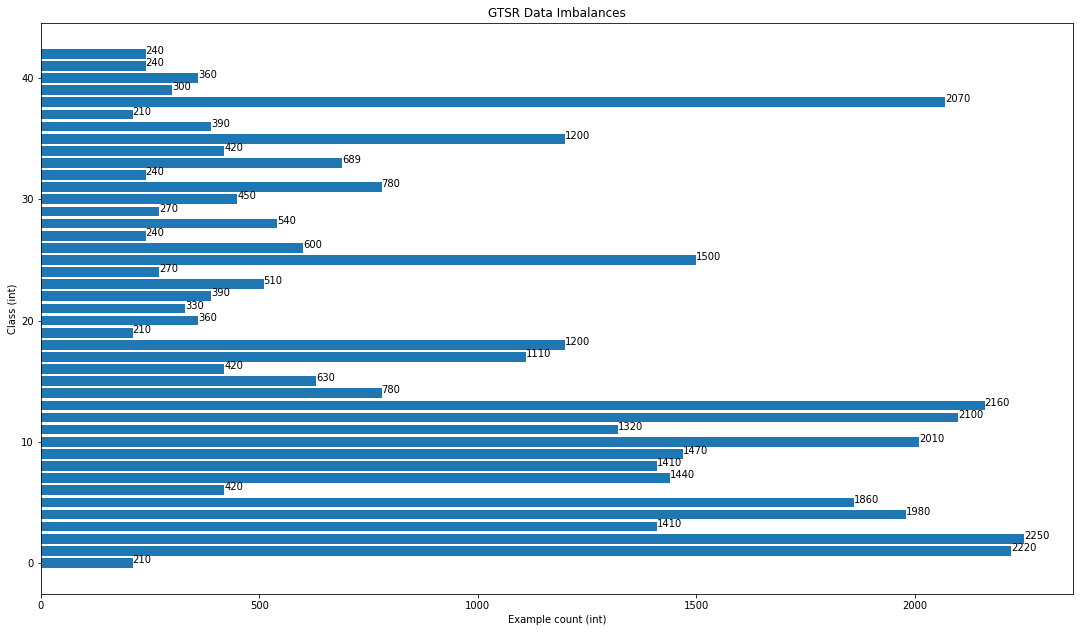

In [7]:
print(type(dataset))

view_data_distribution(dataset)

# Train-Test Split

In [8]:
dataset_size = dataset.__len__()

train_count = int(dataset_size * 0.80)
valid_test_count = dataset_size - train_count

valid_count = int(valid_test_count * 0.5)
test_count = valid_test_count - valid_count

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_count, valid_count, test_count])

print(train_set.__len__(), valid_set.__len__(), test_set.__len__())
print("Total: ", train_set.__len__() + valid_set.__len__() +test_set.__len__())

31367 3921 3921
Total:  39209


In [9]:
# https://discuss.pytorch.org/t/apply-different-transform-data-augmentation-to-train-and-validation/63580/6
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  # image
        y = self.dataset[index][1]   # label      
        return x, y

    def __len__(self):
        return len(self.dataset)

In [10]:
train_dataset = MapDataset(train_set, standard_transform)
train_dataset2 = MapDataset(train_set, data_jitter_transform)
train_dataset3 = MapDataset(train_set, data_jitter_saturation)
train_dataset4 = MapDataset(train_set, flip_transform)

final_train = torch.utils.data.ConcatDataset([train_dataset, train_dataset2, train_dataset3, train_dataset4])
valid_dataset = MapDataset(valid_set, standard_transform)
test_dataset = MapDataset(test_set, standard_transform)

# Handle Imbalances - WeightedRandomSampler

In [11]:
y_train_indicies = train_set.indices
y_train = [dataset.targets[i] for i in y_train_indicies]

In [12]:
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weights = 1./ class_sample_count
samples_weight = np.array([weights[t] for t in y_train])

samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights = samples_weight.type('torch.DoubleTensor'),
    num_samples = len(samples_weight)
)

print(sampler)

# Loading into DataLoaders

In [13]:
train_loader = torch.utils.data.DataLoader(final_train, 
                                           batch_size=32,
                                           sampler=sampler,
                                           num_workers=2,
                                           drop_last=True
                                           )

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=32,
                                           num_workers=2,
                                           drop_last=True,
                                           shuffle=True
                                           )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=32,
                                          num_workers=2,
                                          drop_last=True,
                                          shuffle=True,
                                          )

# Simple Convolutional Neural Network

In [14]:
import torch.nn as nn
import torch.nn.functional as F


nclasses = 43

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1    = nn.Conv2d(3, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool     = nn.MaxPool2d(2, 2)

        self.conv2    = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)

        self.conv3    = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)

        self.fc1      = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn   = nn.BatchNorm2d(350)

        self.fc2      = nn.Linear(350, nclasses)
        # self.dropout  = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))    
        x = self.pool(F.elu(self.conv3(x)))
     
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)

        return x

# Display the Training data

43


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


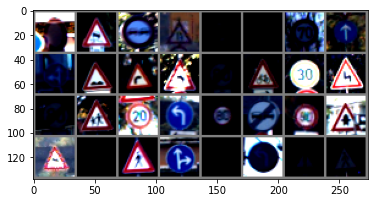

No Vehicles|Slippery Road|No Passing|Road narrows on the right|Speed limit (120km/h)|Speed limit (80km/h)|Speed limit (70km/h)|Ahead only|Go Straight or Left|Bumpy Road|Dangerous curve to the right|Dangerous curve to the left|End of Speed Limit (80km/h)|Bicycles crossing|Speed limit (30km/h)|Double Curve|End of Speed Limit (80km/h)|Children Crossing|Speed limit (20km/h)|Turn left ahead|Speed limit (80km/h)|End of no passing|Speed limit (80km/h)|Right-of-way at the next intersection|Slippery Road|No passing for vehicles over 3.5 metric tons|Pedestrians|Go Straight or Right|No passing for vehicles over 3.5 metric tons|Turn left ahead|General Caution|Pedestrians


In [15]:
def imshow(img):
  img = img/ 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

dataiter = iter(train_loader)
classes = ("Speed limit (20km/h)", "Speed limit (30km/h)" , "Speed limit (50km/h)", "Speed limit (60km/h)",
           "Speed limit (70km/h)" , "Speed limit (80km/h)", "End of Speed Limit (80km/h)", "Speed limit (100km/h)",
           "Speed limit (120km/h)", "No Passing", "No passing for vehicles over 3.5 metric tons", "Right-of-way at the next intersection",
           "Priority road", "Yield", "Stop", "No Vehicles",
           "Vehicles over 3.5 metric tons prohibited", "No entry", "General Caution", "Dangerous curve to the left",
           "Dangerous curve to the right", "Double Curve", "Bumpy Road", "Slippery Road",
           "Road narrows on the right", "Road work", "Traffic signals", "Pedestrians", 
           "Children Crossing", "Bicycles crossing", "Beware of ice/snow","Wild animals crossing",
           "End of all speed and passing limit", "Turn right ahead", "Turn left ahead", "Ahead only", 
           "Go Straight or Right", "Go Straight or Left", "Keep right", "Keep Left", 
            "Roundabout Mandatory", "End of no passing", "End of no passing by vehicles over 3.5 metric tons")

print(len(classes))
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('|'.join(f'{classes[labels[j]]:5s}' for j in range(32)))

# Instantiate CNN - Set up to train via GPU

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = Net()
model = model.to(device)

cuda


In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.001, momentum=0.9)

In [18]:
import time

n_epoch = 10

train_loss_plot = []
train_acc_plot = []
valid_loss_plot = []
valid_acc_plot = []

t1 = time.perf_counter()
for epoch in range(n_epoch):

  train_loss = 0.0
  train_correct = 0
  train_total = 0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)

    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()


  valid_loss = 0.0
  valid_correct = 0
  valid_total = 0
  model.eval()
  for i, data in enumerate(valid_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)

    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)

    valid_total += labels.size(0)
    valid_correct += (predicted == labels).sum().item()

    valid_loss += loss.item()

  
  print(f'Epoch {epoch + 1} \t Training Loss: {(train_loss / len(train_loader)):.4f} \
                               Training Acc: {(train_correct / train_total):.4f} \
                               Validation Loss: {(valid_loss / len(valid_loader)):.4f} \
                               Validation Acc: {(valid_correct / valid_total):.4f}')

  train_loss_plot.append(round(train_loss / len(train_loader), 4))
  train_acc_plot.append(round(train_correct / train_total, 4))
  valid_loss_plot.append(round(valid_loss / len(valid_loader), 4))
  valid_acc_plot.append(round(valid_correct / valid_total, 4))

t2 = time.perf_counter()

print(f'Finished Training in {int(t2-t1)} seconds')

Epoch 1 	 Training Loss: 2.9447                                Training Acc: 0.2222                                Validation Loss: 1.9876                                Validation Acc: 0.4219
Epoch 2 	 Training Loss: 1.0572                                Training Acc: 0.6979                                Validation Loss: 0.8512                                Validation Acc: 0.7285
Epoch 3 	 Training Loss: 0.4329                                Training Acc: 0.8820                                Validation Loss: 0.4862                                Validation Acc: 0.8573
Epoch 4 	 Training Loss: 0.2494                                Training Acc: 0.9346                                Validation Loss: 0.3557                                Validation Acc: 0.9022
Epoch 5 	 Training Loss: 0.1629                                Training Acc: 0.9583                                Validation Loss: 0.3573                                Validation Acc: 0.8817
Epoch 6 	 Training Loss: 0.1202    

In [19]:
epoch_count = range(1, n_epoch + 1)

print(epoch_count)

range(1, 11)


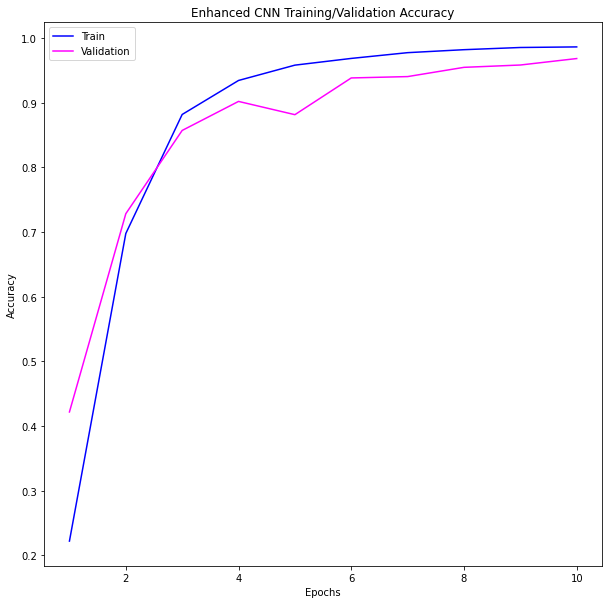

In [20]:
plt.figure(figsize=(10,10))
plt.plot(epoch_count, train_acc_plot, color='blue', label='Train')
plt.plot(epoch_count, valid_acc_plot, color='magenta', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Enhanced CNN Training/Validation Accuracy')
plt.savefig('enhanced_accuracy.png', dpi=300)

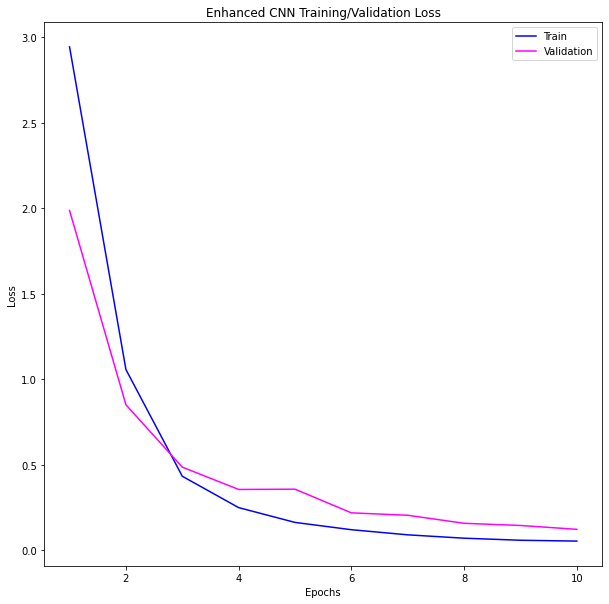

In [21]:
plt.figure(figsize=(10,10))
plt.plot(epoch_count, train_loss_plot, color='blue', label='Train')
plt.plot(epoch_count, valid_loss_plot, color='magenta', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Enhanced CNN Training/Validation Loss')
plt.savefig('enhanced_loss.png', dpi=300)

In [22]:
PATH = './custom_network.pth'
torch.save(model.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


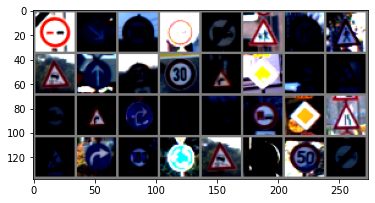

GroundTruth:  No Passing|Keep right|Speed limit (100km/h)|No Passing|End of no passing by vehicles over 3.5 metric tons|Children Crossing|Speed limit (70km/h)|Pedestrians|Slippery Road|Ahead only|Speed limit (80km/h)|Speed limit (30km/h)|Dangerous curve to the right|Priority road|No passing for vehicles over 3.5 metric tons|Road work|No passing for vehicles over 3.5 metric tons|Dangerous curve to the right|Turn right ahead|Traffic signals|General Caution|No passing for vehicles over 3.5 metric tons|Priority road|Road narrows on the right|Road work|Turn right ahead|Speed limit (100km/h)|Roundabout Mandatory|Slippery Road|Keep right|Speed limit (50km/h)|End of no passing


In [23]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '|'.join(f'{classes[labels[j]]:5s}' for j in range(32)))

In [24]:
net = Net()

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [25]:
outputs = net(images)

In [26]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  No Passing Keep right Speed limit (100km/h) No Passing


In [27]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs

nb_classes = 43

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for index, data in enumerate(test_loader):
        images, labels = data
        
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
          confusion_matrix[t.long(), p.long()] += 1

print(f'Accuracy of the network on the {total} test images: {round(100 * correct / total, 4)} %')

Accuracy of the network on the 3904 test images: 97.541 %


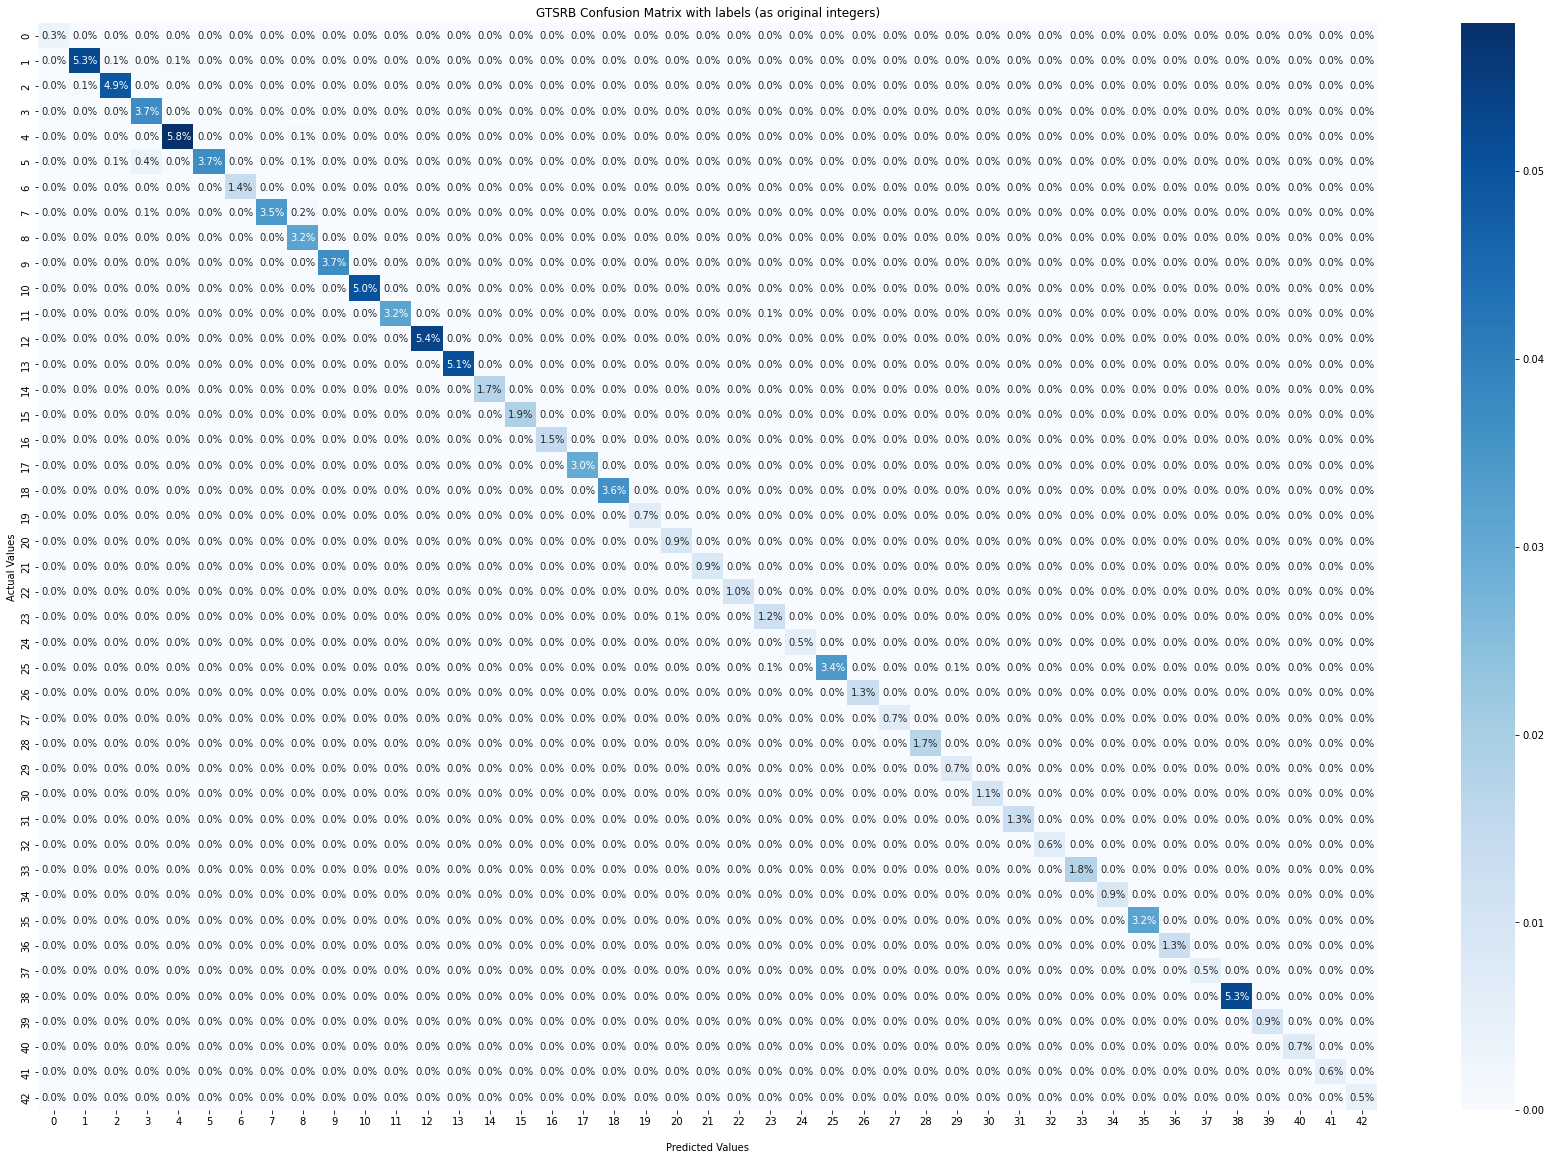

In [28]:
import seaborn as sns

normalized_cf = confusion_matrix / torch.sum(confusion_matrix)

fig, ax = plt.subplots()
fig.set_size_inches(30, 20)

cf = sns.heatmap(normalized_cf, annot=True, fmt='.1%', cmap="Blues")

cf.set_title("GTSRB Confusion Matrix with labels (as original integers)")
cf.set_xlabel('\nPredicted Values')
cf.set_ylabel('Actual Values')

sns.set(rc= {'figure.figsize': (100, 100)})

plt.savefig('confusion_matrix_GTSRB.png', dpi=300)
fig.show()